# Predicting Systolic and Diastolic Blood Pressure based on photopletysmography(PPG) signal

In this project I will compare how different machine learing approaches can be used to predict SBP and DPB based on the PPG signal, discuss their advantages and shortcomings and export the models for further usage. The data will be first read, explored and cleaned. Then, relevant features will be extracted and the the models will be constructed. The models will be then trained and validated to assess their performance. Finally, some fine tuning will be done, in order to minimize the loss functions and achieve best results.

## Data reading and processing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [9]:
!git init

Initialized empty Git repository in /content/gdrive/My Drive/Colab Notebooks/BloodPressure/.git/


In [ ]:
!pip install mat73

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import mat73
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

# feature extraction
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import tree

# pytorch

In [ ]:
DATA_FOLDER = "./data"

In [ ]:
# download and load the data

chunk_size = 4096
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip"
req = requests.get(url, stream = True)
total_size = int(req.headers['content-length'])
 
with open("data.zip", "wb") as file:
    for data in tqdm(iterable=req.iter_content(chunk_size=chunk_size), total = total_size/chunk_size, unit='KB'):
        file.write(data)

100%|█████████▉| 820856/821084.8815917969 [02:51<00:00, 4791.53KB/s]/usr/local/lib/python3.6/dist-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
100%|██████████| 821085/821084.8815917969 [02:51<00:00, 4792.28KB/s]


In [ ]:
# extract the data
if not os.path.exists(DATA_FOLDER):
    os.mkdir(DATA_FOLDER)
        
import zipfile
with zipfile.ZipFile("data.zip", "r") as ref:
    ref.extractall(DATA_FOLDER)

In [ ]:
os.listdir(DATA_FOLDER)

['Part_2.mat', 'Part_4.mat', 'Part_1.mat', '__MACOSX', 'Part_3.mat']

In [ ]:
# load the data from matlab matrix format to pandas dataframes
test_samples = mat73.loadmat(f"{DATA_FOLDER}/Part_1.mat")['Part_1'] # coalesce all matrices into one?

## SBP and DBP preparation

In [ ]:
len(test_samples)

3000

The three signals are:
   - PPG - Photopletysmography
   - ABP - Arterial Bloop Pressure
   - ECG - Electrocardiograph

In [ ]:
# number of entries in each sample
len(test_samples[0])

3

In [ ]:
# number of readings of each type
len(test_samples[0][0])

61000

In [ ]:
sample_size = 125 # the frequency in Hz (1 second samples)

# partition the data into equal length pgg segments
ppg = []
for i in range(len(test_samples)):
    l = test_samples[i][0].size
    for j in range(l // sample_size):
        ppg.append(test_samples[i][0][j * sample_size : (j + 1) * sample_size])

In [ ]:
test_samples[0][0].size

61000

In [ ]:
len(ppg)

662192

Now we can extract SBP and DBP from BP signal.

In [ ]:
sbp = []
dbp = []
bp = []

for i in range(len(test_samples)):
    l = test_samples[i][1].size
    for j in range(l // sample_size):
        temp_bp = test_samples[i][1][j * sample_size : (j + 1) * sample_size]
        # SBP will be maximum and DBP will be minimum of 1 such sampling period
        bp.append(temp_bp)
        sbp.append(max(temp_bp))
        dbp.append(min(temp_bp))

In [ ]:
ppg = np.array(ppg) 
bp = np.array(bp)
sbp = np.array(sbp)
dbp = np.array(dbp)

In [ ]:
ppg.shape

(662192, 125)

In [ ]:
sbp.shape

(662192,)

### Plotting one interval of PPG over BP

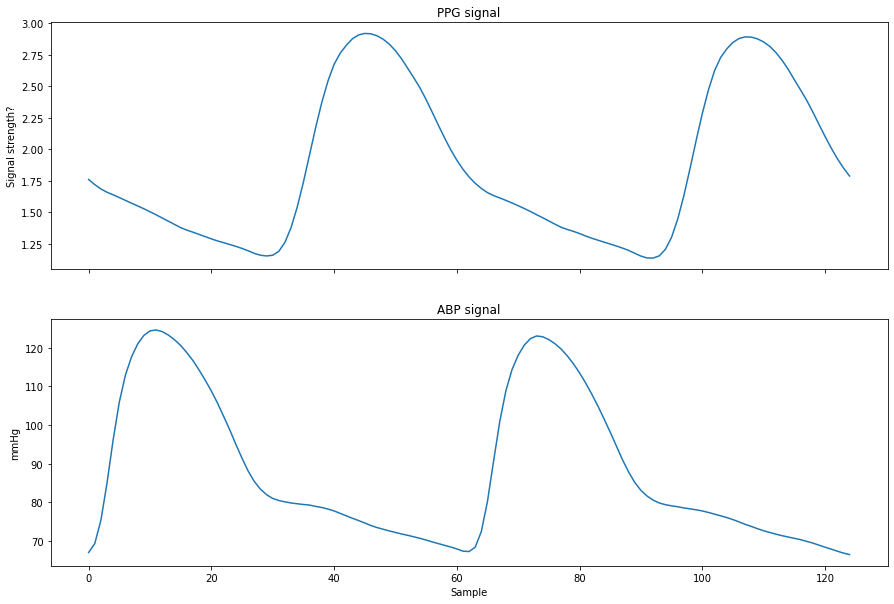

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)

ax[0].set_title("PPG signal")
ax[0].set_ylabel("Signal strength?")
ax[0].plot(ppg[0])

ax[1].set_title("ABP signal")
ax[1].set_ylabel("mmHg")
ax[1].set_xlabel("Sample")
ax[1].plot(bp[0])

### Displaying SBP and DBP

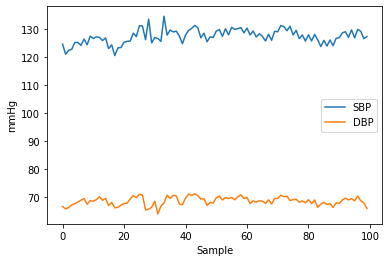

In [ ]:
plt.plot(sbp[:100])
plt.plot(dbp[:100])
plt.ylabel("mmHg")
plt.xlabel("Sample")
plt.legend(["SBP", "DBP"])
plt.show()

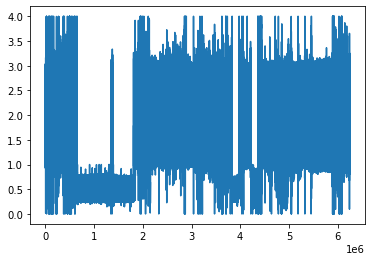

In [ ]:
bigger = np.concatenate(ppg[0:50000])
plt.plot(bigger)

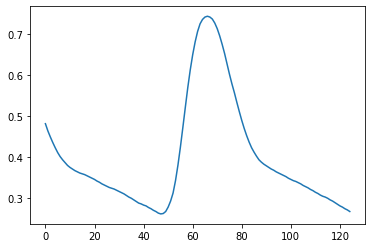

In [ ]:
plt.plot(ppg[9500])

### Baseline model without any features extracted

In [ ]:
# since we want to predict both SBP and DBP we will pack them for each sample
target_bp = []
for i in range(len(ppg)):
    target_bp.append((sbp[i], dbp[i]))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ppg, target_bp, test_size=0.3)

In [ ]:
len(x_train)

463534

In [ ]:
len(y_train)

463534

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mean_absolute_error(y_test, y_pred)

13.86339247983679

In [ ]:
y_pred[0]

array([132.84265271,  65.68463503])

In [ ]:
y_test[0]

(123.08702252492512, 54.50996711818112)

With our baseline Linear Regression of just 1 input variable - the ppg signal we are able to achieve MAE of 13.8 which for now does not say whether this model is good or bad, nevertheless, it gives us some point of reference for future optimizations.

In [ ]:
bp.shape

(662192, 125)

## Temporal Features Extraction

Since classic Machine Learning usually benefits from hand-picking some features from the input data, some features are extracted from the signal periods and assessed for validity. Features were chosen based on most popular ones in the recent scientific papers.
These include:
   - Cycle duration time
   - Time from cycle start to systolic peak
   - Time from systolic peak to cycle end
   - Time from systolic peak to dicrotic notch
   - Time from dicrotic notch to end
   - Ratio between systolic and diastolic amplitude

First we need both derivatives for some features:

In [ ]:
ppg_i = []
ppg_ii = []

for i in range(len(ppg)):
    grad = np.gradient(ppg[i])
    ppg_i.append(grad)
    ppg_ii.append(np.gradient(grad))

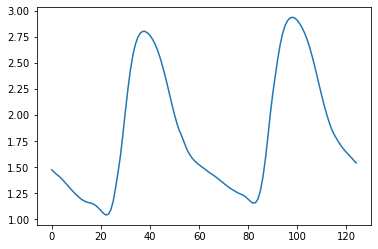

In [ ]:
plt.plot(ppg[4])

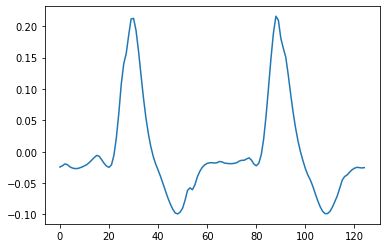

In [ ]:
plt.plot(ppg_i[4])

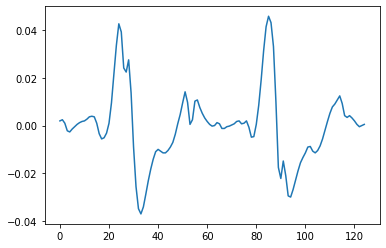

In [ ]:
plt.plot(ppg_ii[4])

Now the relevant features need to be extracted:

In [ ]:
# the sampling speed - 125 Hz
FS = 125

In [ ]:
def time_cycle(inp, sys_1, sys_2, dia_1):
    # sometimes there may be no diastole to the left (no proper one) -> in cases which break the algorithm
    # (signal is not pure in the window), return -1 and then clean the signal
    THRESHOLD = 0.5 # safely basing on the data we can assume such minimal threshold for dia/sys difference
    dia_2 = np.argmin(inp[sys_1:sys_2]) + sys_1
    #print(dia_2 + sys_1)
    cycle_len = dia_2 - dia_1
    return cycle_len, dia_2

In [ ]:
def dicr_notch(inp_ii, sys_1):
    peaks_raw, _ = find_peaks(inp_ii[sys_1:], height=0) # find first above 0 in the ppg'' after systole
    peaks_raw += sys_1
    if len(peaks_raw) < 1:
        return -1
    return peaks_raw[0]

In [ ]:
def time_start_sys(sys_1, dia_1):
    return sys_1 - dia_1

def time_sys_end(sys_1, dia_2):
    return dia_2 - sys_1

def time_sys_dicr(sys_1, dicr):
    return dicr - sys_1

def time_dicr_end(dia_2, dicr):
    return dia_2 - dicr

def ratio_sys_dia(inp, sys_1, dia_1):
    return inp[sys_1] / inp[dia_1]

In [ ]:
def extract_features(inp, inp_ii):
    # calculate the peaks -> systolic (maxima)
    peaks_raw, _ = find_peaks(inp)
    if len(peaks_raw) < 1: # hopeless if could not find any peaks
        return -1, -1, -1, -1, -1, -1
    sys_1 = peaks_raw[0]
    if len(peaks_raw) < 2:
        sys_2 = -1
    else:
        sys_2 = peaks_raw[1]
    
    # to find the beginning of the cycle (diastole), we need to go left of the first systole
    dia_1 = np.argmin(inp[:sys_1])
    
    cycle_len, dia_2 = time_cycle(inp, sys_1, sys_2, dia_1)
    #print(f"{sys_1} : {sys_2} : {dia_1} : {dia_2} : {cycle_len}")
    t_start_sys = time_start_sys(sys_1, dia_1)
    t_sys_end = time_sys_end(sys_1, dia_2)
    
    dicr = dicr_notch(inp_ii, sys_1) # if could not extract dicrotic -> abort, not worth it
    if dicr == -1:
        return -1, -1, -1, -1, -1, -1
    t_sys_dicr = time_sys_dicr(sys_1, dicr)
    t_dicr_end = time_dicr_end(dia_2, dicr)
    ratio = ratio_sys_dia(inp, sys_1, dia_1)

    cycle_len /= FS
    t_start_sys /= FS
    t_sys_end /= FS
    t_sys_dicr /= FS
    t_dicr_end /= FS
    return cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio

#TODO: proof this algorithm against more data, extract more relevant information from 2nd derivative etc
#get the features to the ML models and test them
#finally do the DL approach and some data analysis

In [ ]:
cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio = extract_features(ppg[0], ppg_ii[0])

In [ ]:
cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio 

(0.504, 0.128, 0.376, 0.128, 0.248, 2.5318066157760812)

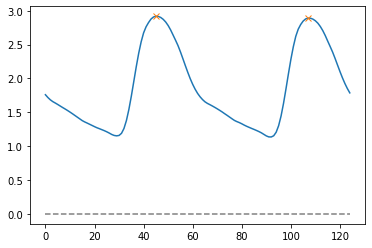

In [ ]:
# easiest -> find peaks with scipy and then categorize them
peaks_raw, _ = find_peaks(ppg[0])
plt.plot(ppg[0])
plt.plot(peaks_raw, ppg[0][peaks_raw], "x")
plt.plot(np.zeros_like(ppg[0]), "--", color="gray")
plt.show()

In [ ]:
# easiest -> find peaks with scipy and then categorize them
peaks_raw, _ = find_peaks(ppg_ii[16303][sys_1:], height=0)
peaks_raw += sys_1
plt.plot(ppg_ii[163030])
plt.plot(peaks_raw, ppg_ii[16303][peaks_raw], "x")
plt.plot(np.zeros_like(ppg_ii[16303]), "--", color="gray")
plt.show()

NameError: ignored

# TODO: increase the sample size (to all of the data)

With these features in place, we can extract now some spectral features.

## Spectral Features Extraction

//#TODO: consider longer periods for DL and shorter for ML (not lose features or get wrong ones)

Additionally, we can extract spectral features, which could help the models:
 - Three largest magnitudes (both values and frequencies)
 - Normalized energy
 - Entropy
 - Histogram - Binned distribution from 0 to 60 Hz (10 bins)
 - Skewness
 - Kurtosis

In [ ]:
def freq_fftfreq(inp):
    freq = fft(inp)
    fftfreqs = fftfreq(FS, 1 / FS)[:FS//2]
    return freq, fftfreqs

In [ ]:
def freq_magnitudes(freq, fftfreqs):
    yf = freq
    xf = fftfreqs
    #plt.plot(xf, np.abs(yf[:FS//2])) # do not normalize (not to loose float precision?)
    #plt.show()
    freq_mag = zip(xf[:FS//2], np.abs(yf[:FS//2]))
    sort = sorted(freq_mag, reverse=True, key=lambda pair: pair[1])
    
    # always ignore DC component
    freqs, mags = [x[0] for x in sort[1:4]], [x[1] for x in sort[1:4]]
    return freqs, mags

In [ ]:
freq, fftfreqs = freq_fftfreq(ppg[0])
freq_magnitudes(freq, fftfreqs)

([2.0, 4.0, 6.0], [48.333431928609485, 20.904005867497023, 5.751411642192075])

In [ ]:
def norm_energy(freq):
    fabs = np.abs(freq[:FS//2])
    energy = 0.
    for f in fabs:
        energy += f * f
    energy /= FS
    return energy

In [ ]:
norm_energy(freq)

457.2957439493177

In [ ]:
def fft_entropy(freq):
    # normalize the input
    freqs = freq / FS

    entr = 0.
    for f in freqs:
        entr += f * np.log(f)
    return -entr

In [ ]:
fft_entropy(freq)

(0.09283046064917708-1.3877787807814457e-17j)

In [ ]:
np.histogram(np.abs(freq) / np.sum(freq), bins=np.arange(0, 125, 125//10))

(array([125,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120]))

In [ ]:
def extract_spectral_features(inp):
    freq, fftfreqs = freq_fftfreq(inp)
    freqs, mags = freq_magnitudes(freq, fftfreqs)
    energy = norm_energy(freq)
    entro = fft_entropy(freq).real
    bins, _ = np.histogram(np.abs(freq) / np.sum(freq), bins=np.arange(0, FS, FS//10))
    skewness = skew(freq).real
    kurt = kurtosis(freq).real
    
    return freqs[0], mags[0], freqs[1], mags[1], freqs[2], mags[2], energy, entro, bins, skewness, kurt

In [ ]:
freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entropy, bins, skewness, kurt = extract_spectral_features(ppg[0])
freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entropy, bins, skewness, kurt

(2.0,
 48.333431928609485,
 4.0,
 20.904005867497023,
 6.0,
 5.751411642192075,
 457.2957439493177,
 0.09283046064917708,
 array([125,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 12.072836992197503,
 137.82673603910223)

# Assemble dataframes and clean the data

In [ ]:
rows = []

for i in range(len(ppg)):#  changed
    cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio = extract_features(ppg[i], ppg_ii[i])
    freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entro, bins, skewness, kurt = extract_spectral_features(ppg[i])
    rows.append((cycle_len, t_start_sys, t_sys_end, t_sys_dicr, t_dicr_end, ratio,
                freq_1, mag_1, freq_2, mag_2, freq_3, mag_3, energy, entro, skewness, kurt, *bins, *ppg[i]))
    
rows = np.array(rows)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in cdouble_scalars
  import sys


In [ ]:
# make a df from the data to clean it
bins = [f"bin_{i}" for i in range(10)]
ppgs = [f"ppg_{i}" for i in range(FS)]
col = ["cycle_len", "t_start_sys", "t_sys_end", "t_sys_dicr", "t_dicr_end", "ratio", 
       "freq_1", "mag_1", "freq_2", "mag_2", "freq_3", "mag_3", "energy", "entropy", "skewness", "kurtosis", *bins, *ppgs]
df = pd.DataFrame(rows, columns=col)
df.head()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,ppg_10,ppg_11,ppg_12,ppg_13,...,ppg_85,ppg_86,ppg_87,ppg_88,ppg_89,ppg_90,ppg_91,ppg_92,ppg_93,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,ppg_100,ppg_101,ppg_102,ppg_103,ppg_104,ppg_105,ppg_106,ppg_107,ppg_108,ppg_109,ppg_110,ppg_111,ppg_112,ppg_113,ppg_114,ppg_115,ppg_116,ppg_117,ppg_118,ppg_119,ppg_120,ppg_121,ppg_122,ppg_123,ppg_124
0,0.504,0.128,0.376,0.128,0.248,2.531807,2.0,48.333432,4.0,20.904006,6.0,5.751412,457.295744,0.092830,12.072837,137.826736,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.759531,1.718475,1.684262,1.657869,1.637341,1.615836,1.593353,1.570870,1.549365,1.526882,1.503421,1.478983,1.453568,1.428152,...,1.247312,1.231672,1.215054,1.196481,1.173998,1.151515,1.136852,1.135875,1.153470,1.205279,1.301075,1.444770,1.630499,1.844575,2.067449,2.280547,2.468231,2.621701,2.727273,2.795699,2.846530,2.877810,2.890518,2.888563,2.874878,2.850440,2.815249,2.766373,2.705767,2.633431,2.551320,2.471163,2.389052,2.296188,2.198436,2.101662,2.009775,1.925709,1.851417,1.786901
1,0.496,0.128,0.368,0.120,0.248,2.504795,2.0,44.746776,4.0,20.383692,6.0,6.454371,413.076984,0.854144,12.154343,138.380236,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.732160,1.687195,1.649071,1.620723,1.599218,1.578690,1.557185,1.535679,1.515152,1.494624,1.473118,1.450635,1.428152,1.403715,...,1.162268,1.149560,1.133920,1.114370,1.090909,1.074291,1.066471,1.070381,1.100684,1.172043,1.290323,1.454545,1.652004,1.867058,2.080156,2.273705,2.436950,2.563050,2.644184,2.692082,2.720430,2.730205,2.725318,2.706745,2.676442,2.635386,2.583578,2.521994,2.450635,2.370479,2.294233,2.217986,2.131965,2.043011,1.956989,1.875855,1.804497,1.743891,1.694037,1.652981
2,0.496,0.120,0.376,0.088,0.288,2.447587,2.0,49.744792,4.0,21.113851,6.0,6.196499,471.519200,0.309773,12.757673,145.562104,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.619746,1.593353,1.572825,1.558162,1.544477,1.528837,1.513196,1.496579,1.478006,1.458456,1.438905,1.417400,1.395894,1.376344,...,1.216031,1.195503,1.173021,1.154448,1.149560,1.163245,1.205279,1.291300,1.427175,1.610948,1.829912,2.065494,2.298143,2.508309,2.684262,2.823069,2.923754,2.990225,3.025415,3.039101,3.041056,3.031281,3.009775,2.976540,2.930596,2.871945,2.800587,2.717498,2.623656,2.521994,2.426197,2.334311,2.234604,2.135875,2.042033,1.956989,1.883675,1.819159,1.765396,1.721408
3,0.496,0.128,0.368,0.080,0.288,2.615911,2.0,48.065007,4.0,22.263068,3.0,5.361363,456.355681,1.761395,12.982167,146.866275,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.685239,1.653959,1.627566,1.607038,1.588465,1.566960,1.543500,1.519062,1.492669,1.466276,1.439883,1.413490,1.388074,1.363636,...,1.136852,1.118280,1.115347,1.140762,1.207234,1.297165,1.418377,1.589443,1.795699,2.015640,2.228739,2.418377,2.573803,2.694037,2.778104,2.831867,2.861193,2.869990,2.864125,2.848485,2.823069,2.785924,2.736070,2.673509,2.598240,2.511241,2.415445,2.311828,2.206256,2.100684,2.009775,1.929619,1.849462,1.775171,1.709677,1.652981,1.604106,1.563050,1.528837,1.499511
4,0.480,0.120,0.360,0.112,0.248,2.690141,2.0,47.676651,4.0,20.187047,1.0,7.113827,436.166857,0.886357,11.977095,130.409735,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.474096,1.449658,1.429130,1.410557,1.388074,1.362659,1.336266,1.308895,1.282502,1.257087,1.233627,1.212121,1.192571,1.177908,...,1.273705,1.400782,1.572825,1.780059,2.004888,2.199413,2.366569,2.529814,2.668622,2.776149,2.852395,2.902248,2.928641,2.936461,2.928641,2.908113,2.874878,2.833822,2.784946,2.724340,2.652004,2.568915,2.477028,2.379277,2.279570,2.181818,2.088954,2.004888,1.929619,1.864125,1.813294,1.773216,1.734115,1.698925,1.668622,1.641251,1.615836,1.591398,1.565005,1.539589


Because there is not much of the data, we can freely remove it without impacting the dataset too heavily.

In [ ]:
idxs = df.loc[df['t_sys_end'] < 0.].index
inf_idxs = df.loc[df.values >= np.finfo(np.float64).max].index
indices = idxs.append(inf_idxs)
df = df.drop(indices)
df.head()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,ppg_10,ppg_11,ppg_12,ppg_13,...,ppg_85,ppg_86,ppg_87,ppg_88,ppg_89,ppg_90,ppg_91,ppg_92,ppg_93,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,ppg_100,ppg_101,ppg_102,ppg_103,ppg_104,ppg_105,ppg_106,ppg_107,ppg_108,ppg_109,ppg_110,ppg_111,ppg_112,ppg_113,ppg_114,ppg_115,ppg_116,ppg_117,ppg_118,ppg_119,ppg_120,ppg_121,ppg_122,ppg_123,ppg_124
0,0.504,0.128,0.376,0.128,0.248,2.531807,2.0,48.333432,4.0,20.904006,6.0,5.751412,457.295744,0.092830,12.072837,137.826736,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.759531,1.718475,1.684262,1.657869,1.637341,1.615836,1.593353,1.570870,1.549365,1.526882,1.503421,1.478983,1.453568,1.428152,...,1.247312,1.231672,1.215054,1.196481,1.173998,1.151515,1.136852,1.135875,1.153470,1.205279,1.301075,1.444770,1.630499,1.844575,2.067449,2.280547,2.468231,2.621701,2.727273,2.795699,2.846530,2.877810,2.890518,2.888563,2.874878,2.850440,2.815249,2.766373,2.705767,2.633431,2.551320,2.471163,2.389052,2.296188,2.198436,2.101662,2.009775,1.925709,1.851417,1.786901
1,0.496,0.128,0.368,0.120,0.248,2.504795,2.0,44.746776,4.0,20.383692,6.0,6.454371,413.076984,0.854144,12.154343,138.380236,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.732160,1.687195,1.649071,1.620723,1.599218,1.578690,1.557185,1.535679,1.515152,1.494624,1.473118,1.450635,1.428152,1.403715,...,1.162268,1.149560,1.133920,1.114370,1.090909,1.074291,1.066471,1.070381,1.100684,1.172043,1.290323,1.454545,1.652004,1.867058,2.080156,2.273705,2.436950,2.563050,2.644184,2.692082,2.720430,2.730205,2.725318,2.706745,2.676442,2.635386,2.583578,2.521994,2.450635,2.370479,2.294233,2.217986,2.131965,2.043011,1.956989,1.875855,1.804497,1.743891,1.694037,1.652981
2,0.496,0.120,0.376,0.088,0.288,2.447587,2.0,49.744792,4.0,21.113851,6.0,6.196499,471.519200,0.309773,12.757673,145.562104,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.619746,1.593353,1.572825,1.558162,1.544477,1.528837,1.513196,1.496579,1.478006,1.458456,1.438905,1.417400,1.395894,1.376344,...,1.216031,1.195503,1.173021,1.154448,1.149560,1.163245,1.205279,1.291300,1.427175,1.610948,1.829912,2.065494,2.298143,2.508309,2.684262,2.823069,2.923754,2.990225,3.025415,3.039101,3.041056,3.031281,3.009775,2.976540,2.930596,2.871945,2.800587,2.717498,2.623656,2.521994,2.426197,2.334311,2.234604,2.135875,2.042033,1.956989,1.883675,1.819159,1.765396,1.721408
3,0.496,0.128,0.368,0.080,0.288,2.615911,2.0,48.065007,4.0,22.263068,3.0,5.361363,456.355681,1.761395,12.982167,146.866275,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.685239,1.653959,1.627566,1.607038,1.588465,1.566960,1.543500,1.519062,1.492669,1.466276,1.439883,1.413490,1.388074,1.363636,...,1.136852,1.118280,1.115347,1.140762,1.207234,1.297165,1.418377,1.589443,1.795699,2.015640,2.228739,2.418377,2.573803,2.694037,2.778104,2.831867,2.861193,2.869990,2.864125,2.848485,2.823069,2.785924,2.736070,2.673509,2.598240,2.511241,2.415445,2.311828,2.206256,2.100684,2.009775,1.929619,1.849462,1.775171,1.709677,1.652981,1.604106,1.563050,1.528837,1.499511
4,0.480,0.120,0.360,0.112,0.248,2.690141,2.0,47.676651,4.0,20.187047,1.0,7.113827,436.166857,0.886357,11.977095,130.409735,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.474096,1.449658,1.429130,1.410557,1.388074,1.362659,1.336266,1.308895,1.282502,1.257087,1.233627,1.212121,1.192571,1.177908,...,1.273705,1.400782,1.572825,1.780059,2.004888,2.199413,2.366569,2.529814,2.668622,2.776149,2.852395,2.902248,2.928641,2.936461,2.928641,2.908113,2.874878,2.833822,2.784946,2.724340,2.652004,2.568915,2.477028,2.379277,2.279570,2.181818,2.088954,2.004888,1.929619,1.864125,1.813294,1.773216,1.734115,1.698925,1.668622,1.641251,1.615836,1.591398,1.565005,1.539589


In [ ]:
pd.options.display.max_rows = 1000
pd.isnull(df).sum() > 0

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df.dtypes

cycle_len      float64
t_start_sys    float64
t_sys_end      float64
t_sys_dicr     float64
t_dicr_end     float64
                ...   
ppg_120        float64
ppg_121        float64
ppg_122        float64
ppg_123        float64
ppg_124        float64
Length: 151, dtype: object

In [ ]:
# clean also the target variables
col = ["SBP" , "DBP"]
df_target = pd.DataFrame(target_bp, columns=col)
df_target = df_target.drop(indices)
df_target.head()

,SBP,DBP
0,124.601310,66.525670
1,120.986846,65.597632
2,122.354481,66.134917
3,122.745234,67.062955
4,125.187439,67.502552


In [ ]:
df.describe()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,ppg_10,ppg_11,ppg_12,ppg_13,...,ppg_85,ppg_86,ppg_87,ppg_88,ppg_89,ppg_90,ppg_91,ppg_92,ppg_93,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,ppg_100,ppg_101,ppg_102,ppg_103,ppg_104,ppg_105,ppg_106,ppg_107,ppg_108,ppg_109,ppg_110,ppg_111,ppg_112,ppg_113,ppg_114,ppg_115,ppg_116,ppg_117,ppg_118,ppg_119,ppg_120,ppg_121,ppg_122,ppg_123,ppg_124
count,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.0,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,...,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000,659694.000000
mean,0.441719,0.127768,0.313950,0.093755,0.220196,2.063948,1.455029,37.019788,2.364275,20.940011,2.944195,13.320352,364.191210,1.207346,11.163958,122.071612,124.999466,0.000291,0.000092,0.000044,0.000015,0.000014,0.000009,0.000012,0.0,0.000002,1.593129,1.593553,1.593969,1.594380,1.594776,1.595160,1.595502,1.595806,1.596107,1.596368,1.596631,1.596857,1.597080,1.597265,...,1.595342,1.595573,1.595784,1.596014,1.596200,1.596392,1.596540,1.596660,1.596737,1.596803,1.596793,1.596754,1.596713,1.596624,1.596509,1.596373,1.596190,1.595984,1.595815,1.595643,1.595484,1.595326,1.595204,1.595060,1.594954,1.594842,1.594730,1.594598,1.594463,1.594298,1.594166,1.594001,1.593846,1.593711,1.593602,1.593520,1.593474,1.593466,1.593496,1.593539
std,0.230912,0.079569,0.187938,0.038975,0.175191,14.216582,0.617846,13.880679,0.916660,7.771510,1.106305,5.954784,150.003632,1.821146,1.277481,21.953689,0.091124,0.047969,0.019192,0.011081,0.005224,0.006156,0.005224,0.004265,0.0,0.001231,0.723283,0.723701,0.724145,0.724609,0.725069,0.725506,0.725893,0.726231,0.726519,0.726767,0.726992,0.727162,0.727308,0.727412,...,0.725778,0.725909,0.726044,0.726203,0.726377,0.726573,0.726773,0.726988,0.727159,0.727317,0.727407,0.727471,0.727509,0.727489,0.727412,0.727293,0.727113,0.726905,0.726678,0.726427,0.726176,0.725937,0.725715,0.725505,0.725333,0.725160,0.725000,0.724835,0.724698,0.724554,0.724424,0.724275,0.724134,0.724009,0.723924,0.723866,0.723862,0.723923,0.724055,0.724232
min,0.016000,0.008000,0.008000,0.008000,-0.184000,1.000244,1.000000,0.076645,1.000000,0.053282,1.000000,0.029635,2.979548,-8.156305,3.427135,31.718036,86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000978,0.000978,0.000978,0.001955,0.001955,0.000978,0.000978,0.000978,0.001955,0.000978,0.000978,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240000,0.064000,0.152000,0.064000,0.064000,1.060246,1.000000,30.553235,2.000000,16.997428,

Briefly exploring the data, it can be seen there are some outliers which should be eliminated in order to make the models' predictions better.

In [ ]:
indices = set()
for x in ["ratio"]:
  q25, q75 = np.percentile(df.loc[:,x], [25, 75])
  intra = q75 - q25

  max = q75 + intra * 1.5
  min = q25 - intra * 1.5

  idxs_1 = df.loc[df[x] < min, x].index
  idxs_2 = df.loc[df[x] > max, x].index
  indices = indices.union(idxs_1).union(idxs_2)


In [ ]:
df.loc[:, "ratio"]

0         2.531807
1         2.504795
2         2.447587
3         2.615911
4         2.690141
            ...   
662187    1.013761
662188    2.565385
662189    1.597778
662190    2.527211
662191    1.760000
Name: ratio, Length: 659694, dtype: float64

In [ ]:
# only some columns are striking, remove only rows where outliers are present in these columns
sus = ["ratio", "mag_1", "mag_2", "mag_3", "energy", "entropy", "skewness", "kurtosis"]
to_remove = set()

indices = set()
for x in sus:
  q25, q75 = np.percentile(df.loc[:,x], [25, 75])
  intra = q75 - q25

  max = q75 + intra * 1.5
  min = q25 - intra * 1.5

  idxs_1 = df.loc[df[x] < min, x].index
  idxs_2 = df.loc[df[x] > max, x].index
  to_remove = to_remove.union(idxs_1).union(idxs_2)

In [ ]:
len(to_remove)

128816

In [ ]:
df.drop(to_remove, inplace=True)
df_target.drop(to_remove, inplace=True)

The data can be saved for later, so that we do not have to do the manual cleaning each time we want to access it. The form of storage is .csv files of fixed number of rows.

In [ ]:
# TODO: store the data in csv

# Exploratory Data Analysis

In order to be better informed about the nature and the relations of the features we extracted, we will plot histograms of several of the most prominent, and a correlation matrix.

In [ ]:
df.describe()

,cycle_len,t_start_sys,t_sys_end,t_sys_dicr,t_dicr_end,ratio,freq_1,mag_1,freq_2,mag_2,freq_3,mag_3,energy,entropy,skewness,kurtosis,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,ppg_10,ppg_11,ppg_12,ppg_13,...,ppg_85,ppg_86,ppg_87,ppg_88,ppg_89,ppg_90,ppg_91,ppg_92,ppg_93,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,ppg_100,ppg_101,ppg_102,ppg_103,ppg_104,ppg_105,ppg_106,ppg_107,ppg_108,ppg_109,ppg_110,ppg_111,ppg_112,ppg_113,ppg_114,ppg_115,ppg_116,ppg_117,ppg_118,ppg_119,ppg_120,ppg_121,ppg_122,ppg_123,ppg_124
count,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.0,530878.0,530878.0,530878.0,530878.0,530878.0,530878.0,530878.0,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,...,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000,530878.000000
mean,0.437076,0.126824,0.310252,0.094249,0.216003,1.911453,1.396775,41.076027,2.367681,22.898421,2.985177,14.320949,405.882206,1.095990,11.102368,121.083553,124.999998,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.708891,1.709092,1.709712,1.710693,1.711974,1.713485,1.715178,1.716977,1.718882,1.720814,1.722786,1.724717,1.726631,1.728457,...,1.727600,1.728339,1.729166,1.730076,1.730986,1.731919,1.732820,1.733681,1.734496,1.735280,1.735958,1.736586,1.737195,1.737756,1.738286,1.738801,1.739283,1.739768,1.740329,1.740915,1.741550,1.742219,1.742978,1.743748,1.744609,1.745540,1.746509,1.747502,1.748575,1.749672,1.750883,1.752109,1.753399,1.754761,1.756199,1.757696,1.759232,1.760786,1.762316,1.763761
std,0.238044,0.080962,0.193300,0.039997,0.178759,0.794221,0.574747,9.491390,0.885677,5.364223,1.081704,4.713537,74.162577,1.673761,1.175300,17.016485,0.001372,0.001372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.586123,0.587318,0.589210,0.591635,0.594416,0.597383,0.600383,0.603311,0.606092,0.608665,0.610984,0.612993,0.614697,0.616067,...,0.606512,0.607357,0.608263,0.609218,0.610187,0.611161,0.612096,0.613001,0.613817,0.614540,0.615093,0.615516,0.615831,0.616016,0.616073,0.616040,0.615928,0.615775,0.615611,0.615419,0.615232,0.615067,0.614930,0.614829,0.614782,0.614758,0.614752,0.614747,0.614764,0.614780,0.614826,0.614878,0.614975,0.615113,0.615322,0.615623,0.616053,0.616614,0.617327,0.618172
min,0.016000,0.008000,0.008000,0.008000,-0.184000,1.000292,1.000000,6.092520,1.000000,3.091518,1.000000,0.612718,156.585861,-3.048650,7.604466,70.340868,124.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139785,0.154448,0.168133,0.176931,0.177908,0.172043,0.163245,0.158358,0.168133,0.195503,0.203324,0.110459,0.054741,0.027370,...,0.000000,0.000000,0.001955,0.000978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.232000,0.056000,0.144000,0.064000,0.064000,1.047292,1.000000,33.998724,2.000000,19.219843,3.000000,10.980272,352.744448,-0.037776,10.171074,107.332011,125.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.225806,1.224829,1.224829,

After removing the outliers, both the standard deviation and the extreme values have been much reduced.

### TODO: discuss outliers?

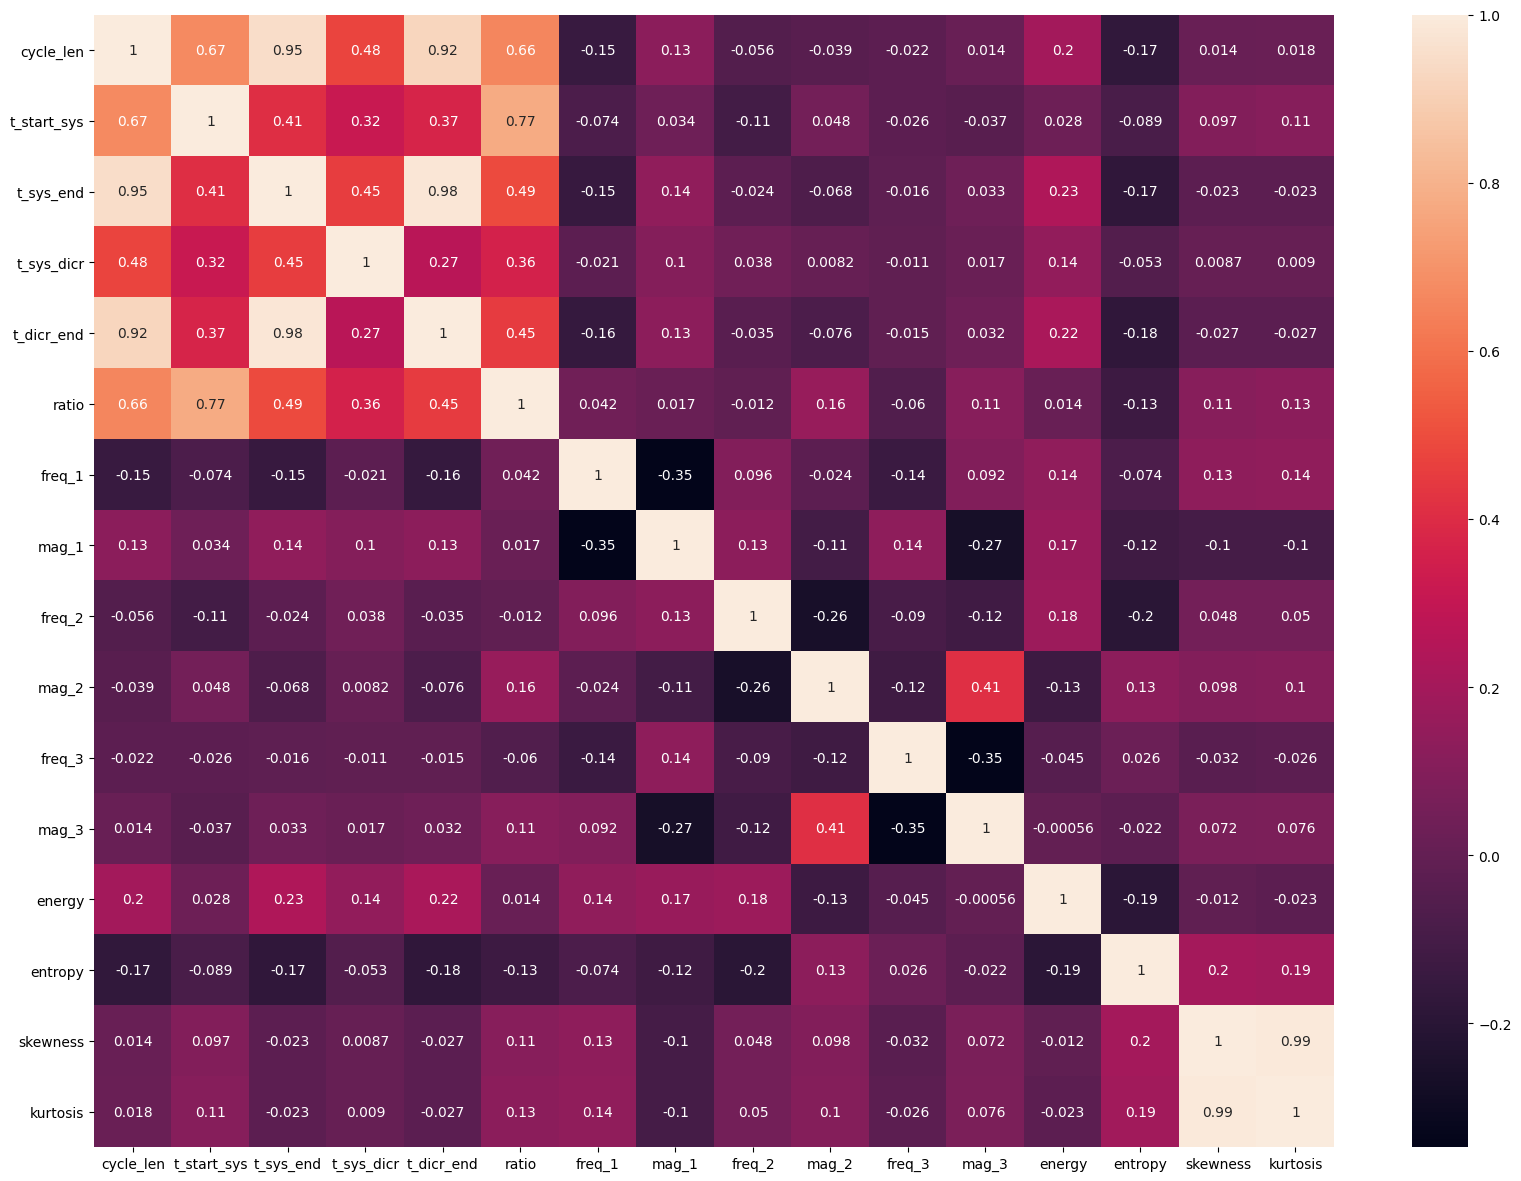

In [ ]:
# correlation plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (20,15)
scatter_var = ["cycle_len", "t_start_sys", "t_sys_end", "t_sys_dicr", "t_dicr_end", "ratio", 
               "freq_1", "mag_1", "freq_2", "mag_2", "freq_3", "mag_3", "energy", "entropy", "skewness", "kurtosis"]
correlation_matrix = df[scatter_var].corr()
sns.heatmap(correlation_matrix, annot=True)

In [ ]:
# scatterplot and distribution together
sns.pairplot(df[scatter_var])

Output hidden; open in https://colab.research.google.com to view.

# Machine Learning

Having the data prepared, we can now proceed with the training of various models to assess which one is the best. The most promising models in the literature are a Random Forest and Linear Regression so we are using them here as well.

The data is further split using K-Fold cross-validation, in order to train the model for a given number of epochs. Then it is finally used to predict on the intact test set.

In [ ]:
folds = KFold(n_splits=10, shuffle=False) # shuffle or not?

In [ ]:
# resplit the data after processing
x_train, x_test, y_train, y_test = train_test_split(df, df_target, test_size=0.3)

## Linear Regression

In [ ]:
# TODO: remove small testing -> it looks like there is some problem with the folds? some fucked up stuff 

In [ ]:
small_df = df.iloc[:10000]
small_df_target = df.iloc[:10000]

In [ ]:
linear = LinearRegression()
forest = RandomForestRegressor(n_estimators=10)
x_train, x_test, y_train, y_test = train_test_split(small_df, small_df_target, test_size=0.3)
linear.fit(x_train, y_train)
forest.fit(x_train, y_train)
predictions = linear.predict(x_test)
predictions_forest = forest.predict(x_test)
error_linear = mean_absolute_error(predictions, y_test)
error_forest = mean_absolute_error(predictions_forest, y_test)
error_linear, error_forest

(3.5495305560957576e-14, 0.12759713033902265)

In [ ]:
linear = LinearRegression()
errors_sbp = []
errors_dbp = []

for i, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    train_data, train_target = x_train.iloc[train_idx], y_train.iloc[train_idx]
    val_data, val_target = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    linear.fit(train_data, train_target) 
    predictions = linear.predict(val_data)
    error_sbp = mean_absolute_error(predictions[:,0], val_target["SBP"].values)
    error_dbp = mean_absolute_error(predictions[:,1], val_target["DBP"].values)
    #print(predictions)
    #print(val_target)
    print(f"Train fold {i} MAE SBP: {error_sbp} MAE DBP: {error_dbp}")
    errors_sbp.append(error_sbp)
    errors_dbp.append(error_dbp)
    
print(f"Average MAE SBP: {np.mean(errors_sbp)} MAE DBP: {np.mean(errors_dbp)}")

Train fold 0 MAE SBP: 17.239078178506883 MAE DBP: 8.38128622540917
Train fold 1 MAE SBP: 17.188226980130775 MAE DBP: 8.491739456051665
Train fold 2 MAE SBP: 17.304694136088226 MAE DBP: 8.412704055547596
Train fold 3 MAE SBP: 17.300621286406894 MAE DBP: 8.50737401444377
Train fold 4 MAE SBP: 17.194986736477798 MAE DBP: 8.48369367938728
Train fold 5 MAE SBP: 17.19412293833339 MAE DBP: 8.479169328475399
Train fold 6 MAE SBP: 17.219238749665994 MAE DBP: 8.447622930714722
Train fold 7 MAE SBP: 17.111601111045765 MAE DBP: 8.391721415935665
Train fold 8 MAE SBP: 17.27179941395793 MAE DBP: 8.406729273796529
Train fold 9 MAE SBP: 17.17768375205948 MAE DBP: 8.449553284257734
Average MAE SBP: 17.220205328267316 MAE DBP: 8.445159366401953


## Random Forest

In [ ]:
forest = RandomForestRegressor(n_estimators=10)
errors_sbp = []
errors_dbp = []

for i, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    train_data, train_target = x_train.iloc[train_idx], y_train.iloc[train_idx]
    val_data, val_target = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    forest.fit(train_data, train_target) 
    predictions = forest.predict(val_data)
    error_sbp = mean_absolute_error(predictions[:,0], val_target["SBP"].values)
    error_dbp = mean_absolute_error(predictions[:,1], val_target["DBP"].values)
    print(f"Train fold {i} MAE SBP: {error_sbp} MAE DBP: {error_dbp}")
    errors_sbp.append(error_sbp)
    errors_dbp.append(error_dbp)
    
print(f"Average MAE SBP: {np.mean(errors_sbp)} MAE DBP: {np.mean(errors_dbp)}")

Train fold 0 MAE SBP: 13.897931040038651 MAE DBP: 7.333046828329489
Train fold 1 MAE SBP: 13.834773397152185 MAE DBP: 7.405353289204189
Train fold 2 MAE SBP: 13.967708462228911 MAE DBP: 7.377430889099216
Train fold 3 MAE SBP: 13.902080105498243 MAE DBP: 7.42312651874443
Train fold 4 MAE SBP: 13.877235760247418 MAE DBP: 7.419372503281473
Train fold 5 MAE SBP: 13.83337363173938 MAE DBP: 7.378336897772033
Train fold 6 MAE SBP: 13.884033704643512 MAE DBP: 7.361787120090475
Train fold 7 MAE SBP: 13.721691550982287 MAE DBP: 7.304540010740355
Train fold 8 MAE SBP: 13.87325109922089 MAE DBP: 7.3557708581273635
Train fold 9 MAE SBP: 13.812499898838585 MAE DBP: 7.333061176411319
Average MAE SBP: 13.860457865059008 MAE DBP: 7.369182609180034


We can show the whole tree to get an overview of splits.

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(forest.estimators_[0], feature_names=df.columns, filled=True)

We can also visualize a single tree from the random forest to inspect its properties and the criteria for splitting.

In [ ]:
# visualize and test different hyperparameters

In [ ]:
# TODO: after consultations
Longer segments?
Remove signal from the training features
MAE should be for both of them
Presentation:
Different combination of features, models fed into the models, tweaking hyperparameters

# Deep Learning

Now we can try to develop a deep learning model to compare with our machine learning counterparts. Because this task is a regression task and the PPG signal is prone to variations, the neural network used for this task is a recurrent neural network (RNN), which is known for compensating the accuracy loss happening over time by residual connections between layers.

In [ ]:
# Read up on the ResNets more and implement first a simpler one and test

# Not needed for the course

# Results

# References

- Slapničar G, Mlakar N, Luštrek M. _Blood Pressure Estimation from Photoplethysmogram Using a Spectro-Temporal Deep Neural Network._ Sensors (Basel). 2019;19(15):3420. Published 2019 Aug 4. doi:10.3390/s19153420
- Serj Haddad, Assim Boukhayma, and Antonino Caizzone -  _Continuous PPG-Based Blood Pressure MonitoringUsing Multi-Linear Regression_
- M. Kachuee, M. M. Kiani, H. Mohammadzade, M. Shabany, _Cuff-Less High-Accuracy Calibration-Free Blood Pressure Estimation Using Pulse Transit Time_, IEEE International Symposium on Circuits and Systems (ISCAS'15), 2015
- Khalid SG, Zhang J, Chen F, Zheng D. _Blood Pressure Estimation Using Photoplethysmography Only: Comparison between Different Machine Learning Approaches._ J Healthc Eng. 2018;2018:1548647. Published 2018 Oct 23. doi:10.1155/2018/1548647